# 프로젝트명 : 타이타닉 생존 예측 모델 (베이스라인)

### 분석 프로세스 

```
1. 데이터 확인
2. EDA(탐색적 데이터 분석) : 데이터 전처리
3. 데이터 학습셋 검증셋 분리
4. 모델 학습 및 평가
5. 모델 선택
```

## 1. 데이터 확인

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # 경고 메시지 출력을 제한한다.

# 데이터 로드
titanic_df = pd.read_csv('./data/titanic/train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2. EDA

In [33]:
import sweetviz as sv
## sweetviz를 이용해 데이터를 분석해보자
train_report = sv.analyze(titanic_df, 
                          pairwise_analysis='off' # 변수간의 관계를 분석하지 않는다.
                          )
train_report.show_html('./data/titanic/train_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report ./data/titanic/train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [2]:
# 학습 데이터 정보
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())



 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### 결측값 보완

- Age : 평균나이
- Cabin, Embarked : 'N' 이라는 글자로 

In [3]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True) # 평균으로 채운다.
titanic_df['Cabin'].fillna('N', inplace=True) # N으로 채운다.
titanic_df['Embarked'].fillna('S', inplace=True) # S가 가장 많으므로
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


#### 문자열 변수 전처리

In [4]:
print(' Sex 값 분포:\n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포:\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포:\n', titanic_df['Embarked'].value_counts())

 Sex 값 분포:
 Sex
male      577
female    314
Name: count, dtype: int64

 Cabin 값 분포:
 Cabin
N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

 Embarked 값 분포:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


#### Cabin(선실)의 경우 선실 등급을 나타내는 첫 번째 알파벳이 중요해 보임

- 선실 등급을 나타내는 첫 번째 알파벳만 추출

In [5]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


<Axes: xlabel='Sex', ylabel='Survived'>

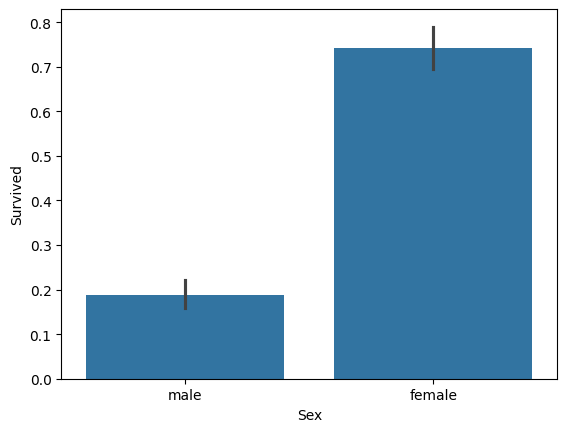

In [6]:
## 성별에 따른 생존자 수 비교
sns.barplot(x='Sex', y='Survived', data=titanic_df)

<Axes: xlabel='Pclass', ylabel='Survived'>

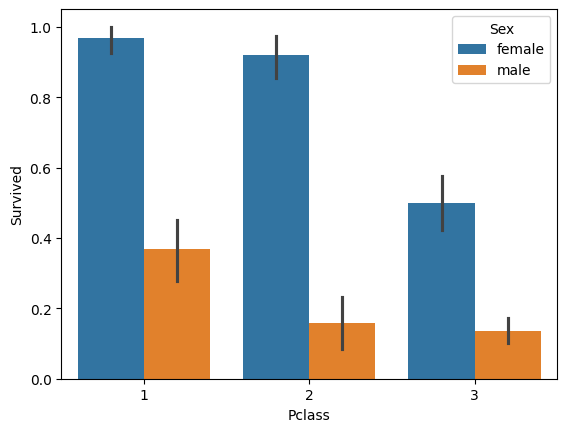

In [7]:
## 객실등급별, 성별별 생존 시각화
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

#### 입력 age에 따라 구분 값을 반환하는 함수 설정.

<Axes: xlabel='Age_cat', ylabel='Survived'>

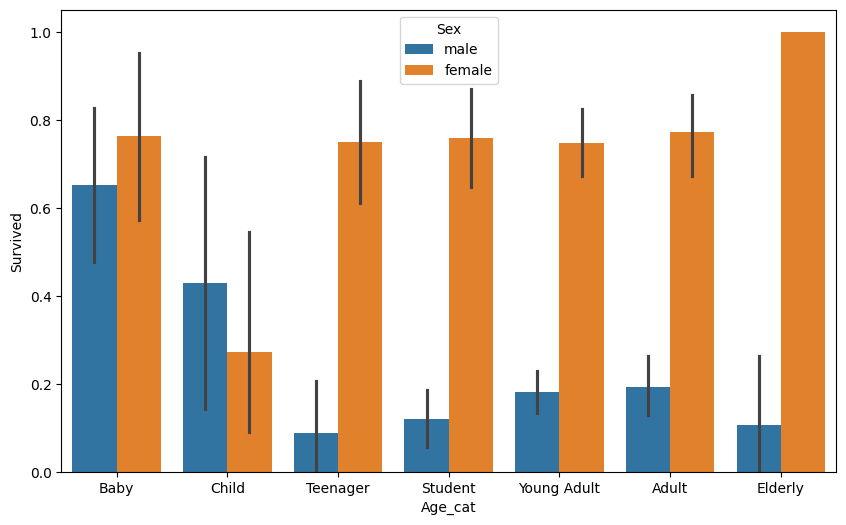

In [8]:

def get_category(age):
    cat = ''
    if age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
        
    return cat

# 막대 그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Baby','Child','Teenager','Student','Young Adult','Adult','Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
# get_category(X)는 입력값으로 'Age' 컬럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))

# 시각화
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)

#### ✅ Age와 Sex, Pclass에 따라 생존율에 차이가 나는 것으로 보아, Age, Sex, Pclass 변수는 생존율에 연관이 있다고 추정한다.

#### 데이터 전처리 함수화

In [9]:
### 결측값 처리 함수
def fillNa(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    df['Fare'].fillna(0, inplace=True) # test 데이터에만 Fare 결측값이 존재
    return df

### 독립변수 전처리 함수
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

### 범주형 변수 인코딩 함수
from sklearn.preprocessing import LabelEncoder
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    category_cols = ['Cabin', 'Sex', 'Embarked']
    for col in category_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

### 전처리 함수
def transform_features(df):
    df = fillNa(df)
    df = drop_features(df)
    df = format_features(df)
    return df

## 3. 훈련/검증셋 나누기

- Survived 변수만 별도 분리해서 종속변수 셋으로 변경

- 앞서 만든, transform_features 함수 사용해서 전처리

In [10]:
# 원본 데이터를 재로딩하고, feature 데이터 셋과 Label 데이터 셋 추출
titanic_df = pd.read_csv('./data/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

# ✅ 앞에서 설정한 데이터 전처리 함수 호출
X_titanic_df = transform_features(X_titanic_df)

In [11]:
# 학습 데이터와 테스트 데이터 세트로 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df,
                                                    y_titanic_df,
                                                    test_size=0.2,
                                                    random_state=2023)



## 4. 모델 학습 및 평가

1. 의사결정트리 : DecisionTreeClassifier
2. 랜덤포레스트 : RandomForestClassifier
3. 로지스틱 회귀 : LogisticRegression 

### 📌 분류모델 성능 평가

- 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지 판단

- 오차행렬(Confusion Matrix) : TN(True Negative), FP(False Positive), FN(False Negative), TP(True Positive)

    - TN: `예측값`을 `N`egative 값 0으로 예측했고, 실제 값도 Negative 값 0
    - FP: `예측값`을 `P`ositive 값 1로 예측했고, 실제 값은 Negative 값 0
    - FN: `예측값`을 `N`egative 값 0으로 예측했고, 실제 값은 Positive 값 1
    - TP: `예측값`을 `P`ositive 값 1으로 예측했고, 실제 값도 Positive 값 1 일때
-     


- 정밀도(Precision) : 예측을 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율

- 재현율(Recall) : 실제 값이 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율

- F1 스코어 : 정밀도와 재현율이 밸런스 있게 한쪽으로 치우치지 않으면 수치가 높아지는 척도

- ROC AUC : 이진 분류 모델의 성능 측정하는 지표. 1에 가까울수록 좋음

#### 모델 성능평가 함수

In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
def get_classfication_evalulator(y_test, pred):
    ## 오차행렬
    confusion = confusion_matrix(y_test, pred)
    ## 정확도
    accuracy = accuracy_score(y_test, pred)
    ## 정밀도
    precision = precision_score(y_test, pred)
    ## 재현율
    recall = recall_score(y_test, pred)
    ## F1 스코어
    f1 = f1_score(y_test, pred)
    print('------ 오차행렬 -------\n', confusion)
    print('\n정확도(accuracy): {:.4f}, 정밀도(precision): {:.4f}, 재현율(recall): {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))
    print('---------------------\n')


#### ROC_AUC 그래프 시각화 

In [13]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    
    for model_name, model in models.items():
        pred_proba_c1 = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, pred_proba_c1)
        roc_auc = roc_auc_score(y_test, pred_proba_c1)
        
        plt.plot(fprs, tprs, label=f'{model_name} (ROC_AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=2023)
rf_clf = RandomForestClassifier(random_state=2023)
lr_clf = LogisticRegression(random_state=2023)


# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('🌲 DecisionTreeClassifier 평가\n')
get_classfication_evalulator(y_test, dt_pred)

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('🌳🌳 RandomForestClassifier 평가\n')
get_classfication_evalulator(y_test, rf_pred)


# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('🧐 LogisticRegression 평가')
get_classfication_evalulator(y_test, lr_pred)


🌲 DecisionTreeClassifier 평가

------ 오차행렬 -------
 [[95 18]
 [17 49]]

정확도(accuracy): 0.8045, 정밀도(precision): 0.7313, 재현율(recall): 0.7424, F1: 0.7368
---------------------

🌳🌳 RandomForestClassifier 평가

------ 오차행렬 -------
 [[100  13]
 [ 19  47]]

정확도(accuracy): 0.8212, 정밀도(precision): 0.7833, 재현율(recall): 0.7121, F1: 0.7460
---------------------

🧐 LogisticRegression 평가
------ 오차행렬 -------
 [[92 21]
 [20 46]]

정확도(accuracy): 0.7709, 정밀도(precision): 0.6866, 재현율(recall): 0.6970, F1: 0.6917
---------------------



### 모델 성능 시각화

- ROC_AUC는 일반적으로 1에 가까울수록 좋으므로, 0.86이 된 RandomForest가 좋음

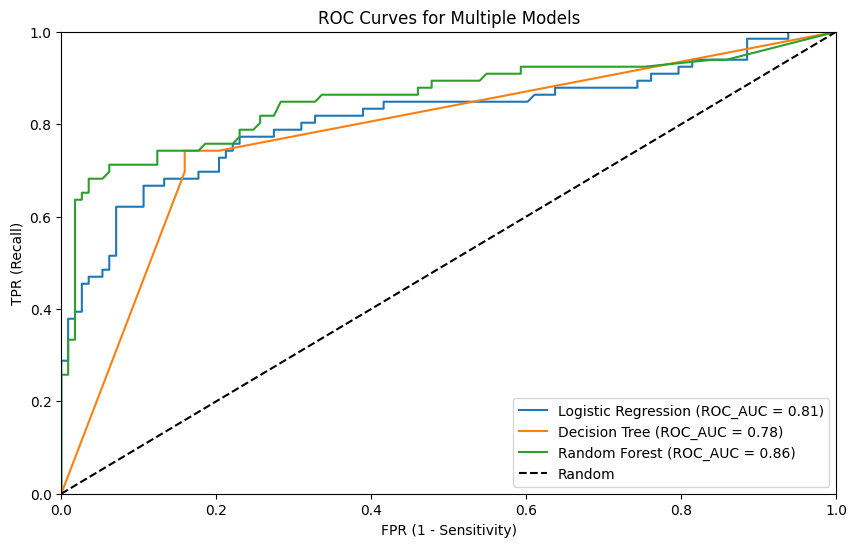

In [15]:
models = {
    'Logistic Regression': lr_clf,
    'Decision Tree': dt_clf,
    'Random Forest': rf_clf
}

plot_roc_curves(models, X_test, y_test)

## 4. 모델 선택

- 준수한 성적의 모델인 RandomForestClassifier를 사용

In [16]:
### 전체 데이터 학습
rf_clf.fit(X_titanic_df, y_titanic_df)

RandomForestClassifier(random_state=2023)

In [17]:
## test.csv 파일을 로드한다.
test_df = pd.read_csv('./data/titanic/test.csv')
result = test_df['PassengerId']


## test 데이터 세트에도 동일한 전처리를 적용한다.
## ✅ 앞에서 설정한 데이터 전처리 함수 호출
test_data = transform_features(test_df)

## 학습에 사용된 feature 데이터 세트를 추출한다.
test_data.head(3)



,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,34.5,0,0,7.8292,7,1
1,3,0,47.0,1,0,7.0000,7,2
2,2,1,62.0,0,0,9.6875,7,1


In [18]:
## 예측을 수행한다.
pred = rf_clf.predict(test_data)

## 예측 결과를 Survived 컬럼으로 입력한다.
test_data['Survived'] = pred

## 예측 결과를 PassengerId와 Survived 컬럼으로만 제한해 CSV 파일로 저장한다.
test_data['PassengerId'] = result
submission = test_data[['PassengerId','Survived']]
submission.to_csv('./data/titanic/submission_baseline.csv', index=False) ## 0.75598 점수를 얻었다.

### ML 모델 파라미터 엔지니어링

- 기본 사용 예제 코드입니다.

- 캐글 제출시 더 낮은 스코어를 얻습니다. 이는 타이타닉 데이터셋 자체가 양이 작으므로 발생합니다.

- GridSearchCV를 이용하여 하이퍼 파라미터를 찾고, 그 파라미터로 모델에 적용하는 방법 예시입니다.

In [31]:
from sklearn.model_selection import GridSearchCV

dt_param_grid = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 5, 8]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 7, 10, 20],
    'min_samples_split': [2, 3, 6],
    'min_samples_leaf': [1, 5, 6, 8]
}

lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}


grid_dt_clf = GridSearchCV(dt_clf, param_grid=dt_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_rf_clf = GridSearchCV(rf_clf, param_grid=rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_lr_clf = GridSearchCV(lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=5, n_jobs=-1)


grid_dt_clf.fit(X_train, y_train)
grid_rf_clf.fit(X_train, y_train)
grid_lr_clf.fit(X_train, y_train)


print('Decision Tree - GridSearchCV 최적 하이퍼 파라미터:', grid_dt_clf.best_params_)
print('Decision Tree - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dt_clf.best_score_))

print('Random Forest - GridSearchCV 최적 하이퍼 파라미터:', grid_rf_clf.best_params_)
print('Random Forest - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rf_clf.best_score_))

print('Logistic Regression - GridSearchCV 최적 하이퍼 파라미터:', grid_lr_clf.best_params_)
print('Logistic Regression - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lr_clf.best_score_))


best_dt_clf = grid_dt_clf.best_estimator_
best_rf_clf = grid_rf_clf.best_estimator_
best_lr_clf = grid_lr_clf.best_estimator_


dt_predictions = best_dt_clf.predict(X_test)
rf_predictions = best_rf_clf.predict(X_test)
lr_predictions = best_lr_clf.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print('Decision Tree - 테스트셋에서 정확도: {0:.4f}'.format(dt_accuracy))
print('Random Forest - 테스트셋에서 정확도: {0:.4f}'.format(rf_accuracy))
print('Logistic Regression - 테스트셋에서 정확도: {0:.4f}'.format(lr_accuracy))

Decision Tree - GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Decision Tree - GridSearchCV 최고 정확도: 0.8203
Random Forest - GridSearchCV 최적 하이퍼 파라미터: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest - GridSearchCV 최고 정확도: 0.8132
Logistic Regression - GridSearchCV 최적 하이퍼 파라미터: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression - GridSearchCV 최고 정확도: 0.8034
Decision Tree - 테스트셋에서 정확도: 0.7877
Random Forest - 테스트셋에서 정확도: 0.8436
Logistic Regression - 테스트셋에서 정확도: 0.7709


/Users/seedbox/project/DATA_STUDY/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seedbox/project/DATA_STUDY/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seedbox/project/DATA_STUDY/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seedbox/project/DATA_STUDY/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seedbox/project/DATA_STUDY/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

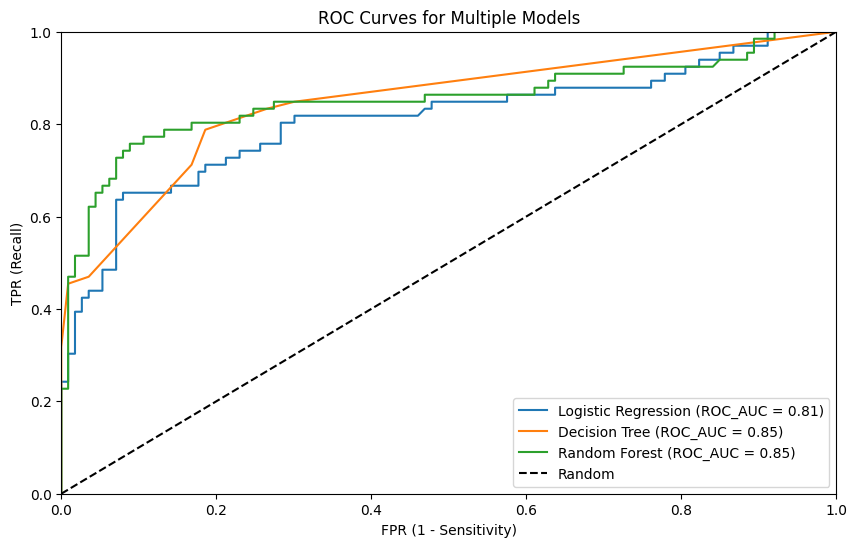

In [32]:
models = {
    'Logistic Regression': best_lr_clf,
    'Decision Tree': best_dt_clf,
    'Random Forest': best_rf_clf
}


plot_roc_curves(models, X_test, y_test)

In [21]:
## test.csv 파일을 로드한다.
test_df = pd.read_csv('./data/titanic/test.csv')
result = test_df['PassengerId']
test_data = transform_features(test_df)

## best_rf_clf 로 예측
pred = best_rf_clf.predict(test_data)


## 예측 결과를 Survived 컬럼으로 입력한다.
test_data['Survived'] = pred

## 예측 결과를 PassengerId와 Survived 컬럼으로만 제한해 CSV 파일로 저장한다.
test_data['PassengerId'] = result
submission = test_data[['PassengerId','Survived']]
submission.to_csv('./data/titanic/submission_baseline2.csv', index=False) ## 0.75119 점수를 얻었다.